## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.25
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0730 15:05:06.740340 16688 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0730 15:05:06.741828 16688 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 15:05:06.930187 16688 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 15:05:06.934155 16688 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 15:05:06.945562 16688 depr

Experiment with Regulizer = 0.010000


W0730 15:05:07.175529 16688 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

W0730 15:05:07.496485 16688 deprecation.py:323] From C:\Users\Rosa\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 19s 384us/step - loss: 15.2113 - acc: 0.1947 - val_loss: 14.0334 - val_acc: 0.3020
Epoch 2/50
50000/50000 [==============================] - 15s 296us/step - loss: 13.1448 - acc: 0.2751 - val_loss: 12.1858 - val_acc: 0.3386
Epoch 3/50
50000/50000 [==============================] - 14s 281us/step - loss: 11.4540 - acc: 0.3135 - val_loss: 10.6491 - val_acc: 0.3551
Epoch 4/50
50000/50000 [==============================] - 14s 284us/step - loss: 10.0306 - acc: 0.3343 - val_loss: 9.3302 - val_acc: 0.3743
Epoch 5/50
50000/50000 [==============================] - 14s 286us/step - loss: 8.8204 - acc: 0.3483 - val_loss: 8.2138 - val_acc: 0.3816
Epoch 6/50
50000/50000 [==============================] - 14s 285us/step - loss: 7.7923 - acc: 0.3589 - val_loss: 7.2658 - val_acc: 0.3932
Epoch 7/50
50000/50000 [==============================] - 14s 282us/step - loss: 6.9143 - acc: 0.3687 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 283us/step - loss: 2.3241 - acc: 0.1878 - val_loss: 2.1168 - val_acc: 0.2984
Epoch 2/50
50000/50000 [==============================] - 13s 267us/step - loss: 2.1082 - acc: 0.2843 - val_loss: 1.9819 - val_acc: 0.3568
Epoch 3/50
50000/50000 [==============================] - 13s 263us/step - loss: 2.0183 - acc: 0.3235 - val_loss: 1.9185 - val_acc: 0.3790
Epoch 4/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.9604 - acc: 0.3471 - val_loss: 1.8656 - val_acc: 0.3936
Epoch 5/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.9146 - acc: 0.3669 - val_loss: 1.8203 - val_acc: 0.4057
Epoch 6/50
50000/50000 [==============================] - 18s 369us/step - loss: 1.8790 - acc: 0.3791 - val_loss: 1.7826 - val_acc: 0.4225
Epoch 7/50
50000/50000 [==============================] - 20s 409us/step - loss: 1.8487 - acc: 0.3883 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 285us/step - loss: 2.1513 - acc: 0.2020 - val_loss: 1.9572 - val_acc: 0.3126
Epoch 2/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.9563 - acc: 0.2903 - val_loss: 1.8364 - val_acc: 0.3519
Epoch 3/50
50000/50000 [==============================] - 15s 307us/step - loss: 1.8758 - acc: 0.3230 - val_loss: 1.7735 - val_acc: 0.3795
Epoch 4/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.8202 - acc: 0.3454 - val_loss: 1.7159 - val_acc: 0.3933
Epoch 5/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.7744 - acc: 0.3643 - val_loss: 1.6752 - val_acc: 0.4122
Epoch 6/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.7367 - acc: 0.3761 - val_loss: 1.6386 - val_acc: 0.4172
Epoch 7/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.7065 - acc: 0.3903 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 313us/step - loss: 2.1603 - acc: 0.1999 - val_loss: 1.9507 - val_acc: 0.3073
Epoch 2/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.9593 - acc: 0.2857 - val_loss: 1.8426 - val_acc: 0.3485
Epoch 3/50
50000/50000 [==============================] - 19s 374us/step - loss: 1.8752 - acc: 0.3239 - val_loss: 1.7755 - val_acc: 0.3749
Epoch 4/50
50000/50000 [==============================] - 16s 322us/step - loss: 1.8216 - acc: 0.3458 - val_loss: 1.7273 - val_acc: 0.3917
Epoch 5/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.7782 - acc: 0.3629 - val_loss: 1.6901 - val_acc: 0.3997
Epoch 6/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.7421 - acc: 0.3762 - val_loss: 1.6480 - val_acc: 0.4184
Epoch 7/50
50000/50000 [==============================] - 14s 287us/step - loss: 1.7195 - acc: 0.3863 - val_loss: 1.

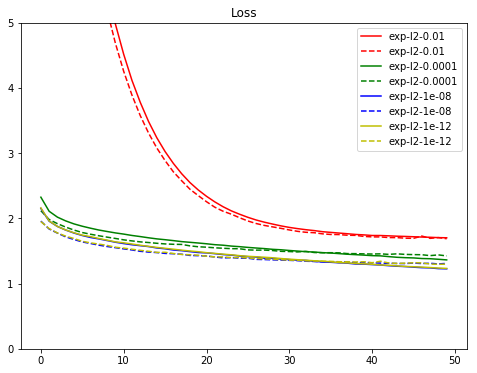

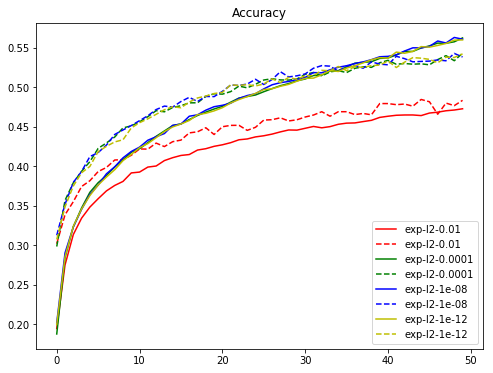

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()